In [46]:
import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import LogNorm
import unidecode

import matplotlib as mpl
font = {        'size'   : 15}
mpl.rc('font', **font)

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
import imageio

In [9]:
# Getting the top 19 cities
iwiw_codes = [379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 396, 1842, 2103]
iwiw_code_dict= {379: 'Budapest', 380: 'Debrecen', 381: 'Miskolc', 382: 'Szeged', 383: 'Pecs', 384: 'Gyor', 385: 'Nyiregyhaza', 386: 'Kecskemet',
 387: 'Szekesfehervar', 388: 'Szombathely', 389: 'Szolnok', 390: 'Tatabanya', 391: 'Kaposvar', 392: 'Bekescsaba', 393: 'Zalaegerszeg',
 394: 'Veszprem', 396: 'Eger', 1842: 'Szekszard', 2103: 'Salgotarjan'}
city_to_code = {v:k for k,v in iwiw_code_dict.items()}

# useful masks
mask_SL_t = ~np.eye(19,dtype=bool) # mask for self loops in a snapshot
mask_SL = np.array([mask_SL_t]*11) # mask for self loops across all snapshots

In [3]:
def remove_accent(df):
    # input is the reduced df where all values are strings
    return df.apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))

def names_to_ids(df):
    # input is the reduced df where all values are strings
    return df.apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')).applymap(lambda x: city_to_code[x])

def users_per_city(W):
    n = np.zeros([W.shape[0],W.shape[1]],dtype='int')
    for t in range(W.shape[0]):
        n[t,:] = np.sum(W[0,:,:],axis=1) + np.sum(W[0:t+1,:,:],axis=(0,2))
    n[n==0]+=1 # artificially ensuring no cities have 0 users!
    return n  

In [77]:
shortest_paths = pd.read_csv('../simplified_roads/hungary/data/shortest_paths.csv')
shortest_paths[['source','target']]=names_to_ids(shortest_paths[['source','target']])
shortest_paths['length'] = shortest_paths['length'].apply(lambda x:x/1000)

node_list=shortest_paths['source'].unique() # all the unique nodes
Years=shortest_paths['year'].unique() # all the unique years

shortest_paths.head()

In [60]:
graphs = {y:nx.from_pandas_edgelist(shortest_paths[shortest_paths['year']==y],
                                    source='source',target='target',edge_attr=['travel_time','length'],) 
          for y in Years}

In [61]:
travel_time_tensor = np.array([nx.to_numpy_array(graphs[y],dtype=np.float32,weight='travel_time') for y in Years])
length_tensor = np.array([nx.to_numpy_array(graphs[y],dtype=np.float32,weight='length') for y in Years])

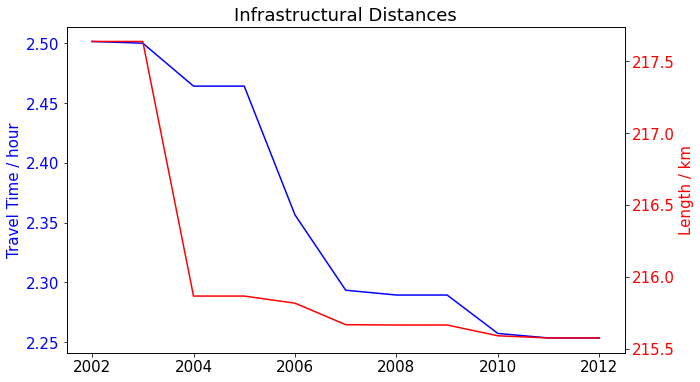

In [62]:
fig,axs=plt.subplots(figsize=(10,6),nrows=1)
axs.set_title("Infrastructural Distances")
color='blue'
axs.plot(Years,[travel_time_tensor[t,:,:][mask_SL_t].mean() for t in range(travel_time_tensor.shape[0])],color=color)
axs.set_ylabel("Travel Time / hour",color=color)
axs.tick_params(axis='y', labelcolor=color)

color = 'red'
ax2 = axs.twinx()
ax2.plot(Years,[length_tensor[t,:,:][mask_SL_t].mean() for t in range(length_tensor.shape[0])],color=color)
ax2.set_ylabel("Length / km",color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.savefig('../analysis/Figures/mean_infrastructural_distances.png',bbox_inches='tight')

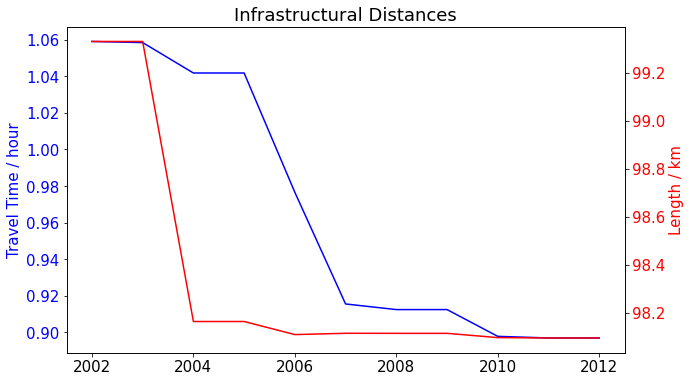

In [63]:
fig,axs=plt.subplots(figsize=(10,6),nrows=1)
axs.set_title("Infrastructural Distances")
color='blue'
axs.plot(Years,[travel_time_tensor[t,:,:][mask_SL_t].std() for t in range(travel_time_tensor.shape[0])],color=color)
axs.set_ylabel("Travel Time / hour",color=color)
axs.tick_params(axis='y', labelcolor=color)

color = 'red'
ax2 = axs.twinx()
ax2.plot(Years,[length_tensor[t,:,:][mask_SL_t].std() for t in range(length_tensor.shape[0])],color=color)
ax2.set_ylabel("Length / km",color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.savefig('../analysis/Figures/std_infrastructural_distances.png',bbox_inches='tight')

In [66]:
for t,y in enumerate(Years):
    fig = plt.figure(figsize=(10,6))
    plt.hist(length_tensor[t,:,:][mask_SL_t],color='forestgreen',bins=range(0,510,50))
    plt.ylabel("Counts")
    plt.ylim([0,75])
    plt.xlabel("Distance / hour")
    plt.title('Distance Distribution %s'%y)
    
    fig.savefig('../analysis/Figures/Distributions/length_%s.png'%y,bbox_inches='tight')
    plt.close()

In [67]:
images=[imageio.imread('../analysis/Figures/Distributions/length_%s.png'%year)  for year in Years]
#duration of each picture is 1 second!
imageio.mimsave('../analysis/Figures/Distributions/movie_length.gif', images, duration=0.5 )

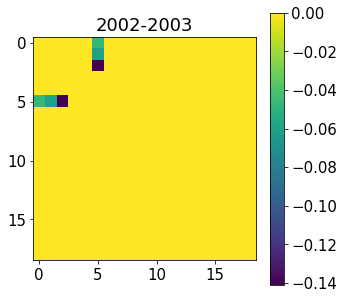

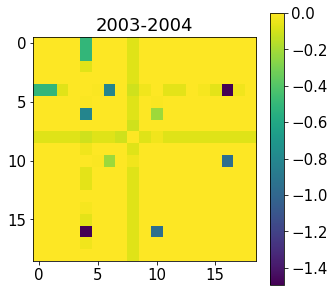

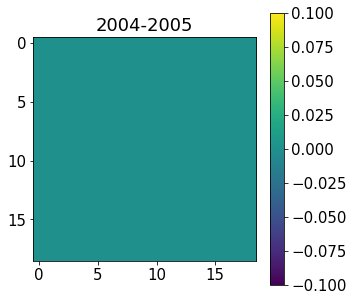

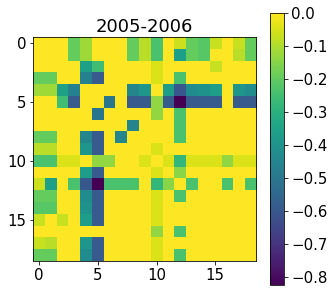

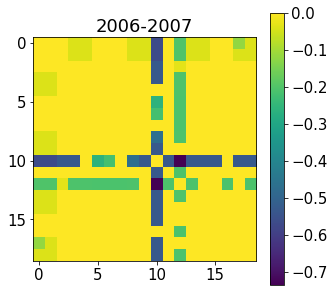

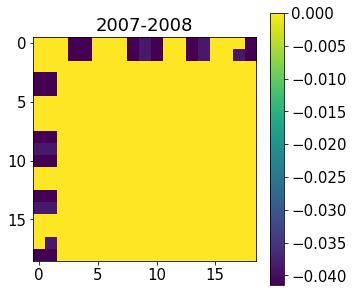

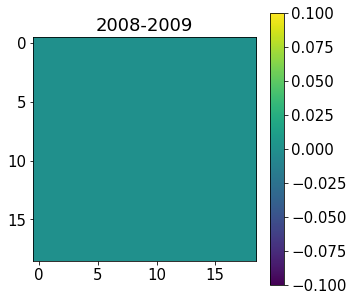

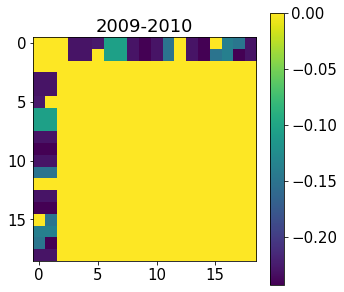

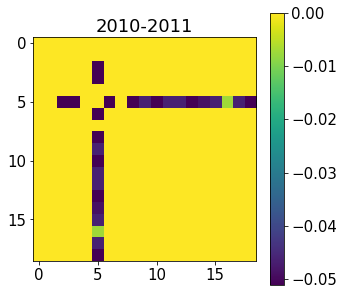

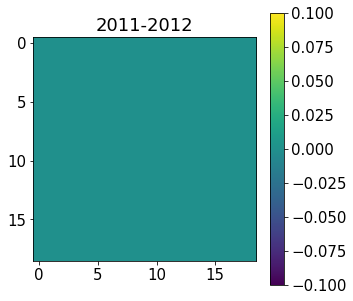

In [68]:
for t in range(S.shape[0]-1):
    plt.figure(figsize=(5,5))
    im=plt.imshow(np.diff(travel_time_tensor,axis=0)[t,:,:])#,
#                norm=LogNorm(vmin=D[D>0].min(),vmax=D.max()))
    plt.colorbar(im)
    title = str(Years[t])+'-'+str(Years[t+1])
    plt.title(title)

In [ ]:
fig,axs=plt.subplots(figsize=(10,6),nrows=1)
axs.set_title("Infrastructural Distances")
color='blue'
axs.plot(Years,[travel_time_tensor[t,:,:][mask_SL_t].std() for t in range(travel_time_tensor.shape[0])],color=color)
axs.set_ylabel("Travel Time / hour",color=color)
axs.tick_params(axis='y', labelcolor=color)

color = 'red'
ax2 = axs.twinx()
ax2.plot(Years,[length_tensor[t,:,:][mask_SL_t].std() for t in range(length_tensor.shape[0])],color=color)
ax2.set_ylabel("Length / km",color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Reading social data

In [78]:
connections = pd.read_csv('../analysis/all_spatiosocial_data.csv')
graphs_S = {y:nx.from_pandas_edgelist(connections[connections['Year']==y],
                                    source='CityID_From',target='CityID_To',edge_attr='Connections') 
          for y in Years}

S = np.array([nx.to_numpy_array(graphs_S[y],dtype=np.float32,weight='Connections') for y in Years])

In [83]:
invitations_iwiw = pd.read_csv('../data/invitation_counts.csv.gz')
mask1 = invitations_iwiw["CityId"].map(lambda i: i in iwiw_codes)
mask2 = invitations_iwiw["InvitorCityId"].map(lambda i: i in iwiw_codes)
reduced_df = invitations_iwiw[mask1&mask2]
graphs_W = {year:nx.from_pandas_edgelist(reduced_df[reduced_df['RegYear']==year],
                                                        source='InvitorCityId',target='CityId',edge_attr='w',
                                                        create_using=nx.DiGraph)
            for year in Years}

# asymmetric, weighted tensor of size T x N x N
W = np.array([nx.to_numpy_array(graphs_W[y],dtype=np.float32,weight='w') for y in Years])
for i in range(W.shape[1]):
    W[:,i,i]=0

# Null Models

In [97]:
def gravity_model(dist,alpha=1,beta=1,gamma=2):
    return np.array([np.outer(n[t,:]**alpha,n[t,:]**beta)/(dist[t,:,:]**gamma) for t in range(n.shape[0])])

In [98]:
n = users_per_city(W)
mu = travel_time_tensor.mean(axis=(1,2))/n.mean(axis=1)**2

In [99]:
alpha = 1
beta = 1
gamma = 2
n=users_per_city(W) # natively two cities have 0 users to begin with
S_gravity_tt = gravity_model(travel_time_tensor,gamma=gamma)
S_gravity_l = gravity_model(length_tensor,gamma=gamma)

for i in range(S.shape[1]):
    S_gravity_tt[:,i,i]=0
    S_gravity_l[:,i,i]=0

/home/jbara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [101]:
S_mean_t = [S[t,:,:][mask_SL_t].mean() for t in range(S.shape[0])]
S_g_tt_mean_t = [S_gravity_tt[t,:,:][mask_SL_t].mean() for t in range(S.shape[0])]
S_g_l_mean_t = [S_gravity_l[t,:,:][mask_SL_t].mean() for t in range(S.shape[0])]

print(S_mean_t)
print(S_g_tt_mean_t)
print(n.mean(axis=1))

[1.9473684, 6.6900587, 14.619883, 70.61404, 331.44446, 503.91812, 571.55554, 615.91815, 649.35675, 656.1579, 656.65497]
[174.71833403368677, 958.7945244783384, 3898.023817906159, 82402.64708258715, 2431308.5121824327, 5827589.037997229, 7641659.054352584, 8958062.864233848, 10339925.054671982, 10600268.342409091, 10616915.13116]
[  35.15789474   77.78947368  149.10526316  653.05263158 3000.52631579
 4552.78947368 5161.52631579 5560.78947368 5861.73684211 5922.94736842
 5927.42105263]


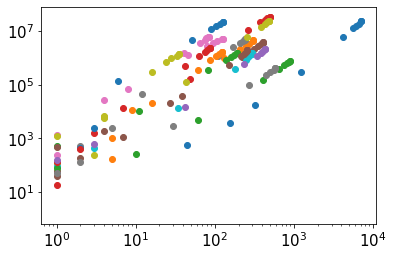

In [90]:
for j in range(S.shape[1]):
    plt.scatter(S[:,4,j],S_gravity_tt[:,4,j])
    
plt.xscale('log')
plt.yscale('log')

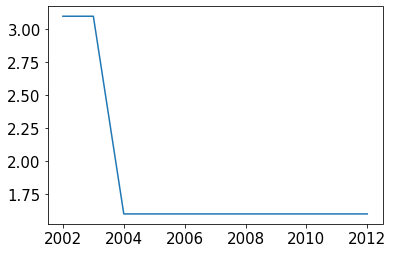

In [17]:
plt.plot(Years,travel_time_tensor[:,4,16])
# plt.plot(Years,S_gravity_tt[:,4,16])
# plt.plot(Years,S_gravity_l[:,4,16])

# plt.scatter(S_gravity_tt[mask_SL],S[mask_SL])

# for j in range(1,S.shape[1]):
#     if j != 4:
#         plt.scatter(S[:,4,j],S_gravity_tt[:,4,j],label='4,'+str(j))
# plt.scatter(S_gravity_tt[:,4,0],S[:,4,0],label='(4,0)')
# plt.scatter(S_gravity_tt[:,4,0],S[:,4,10],label='(4,10)')
# plt.legend()
# plt.xscale('log')
# plt.yscale('log')

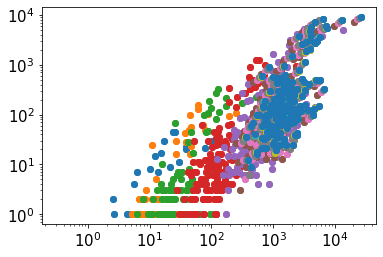

In [119]:
for t in range(S.shape[0]):
    plt.scatter(np.sqrt(S_gravity_tt[t,:,:]),S[t,:,:])
# plt.plot(np.linspace(0,S_gravity_tt[mask_SL].max()),np.linspace(0,S_gravity_tt[mask_SL].max()))
plt.xscale('log')
plt.yscale('log')

# Correlations between null and empirical

In [110]:
rho_all = np.corrcoef(S_gravity_tt[mask_SL],S[mask_SL])[0,1]
rho_t = np.array([np.corrcoef(S_gravity_tt[t,:,:][mask_SL_t],S[t,:,:][mask_SL_t])[0,1] for t in range(S.shape[0])])
rho_ij = np.array([[np.corrcoef(S_gravity_tt[:,i,j],S[:,i,j])[0,1] for i in range(S.shape[1])] for j in range(S.shape[2])])

print('Aggregating all')

/home/jbara/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


# Static network measures on distances